# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

For this assignment, you will use reinforcement learning to solve the [Towers of Hanoi](https://en.wikipedia.org/wiki/Tower_of_Hanoi) puzzle.  

To accomplish this, you must modify the code discussed in lecture for learning to play Tic-Tac-Toe.  Modify the code  so that it learns to solve the three-disk, three-peg
Towers of Hanoi Puzzle.  In some ways, this will be simpler than the
Tic-Tac-Toe code.  

Steps required to do this include the following:

  - Represent the state, and use it as a tuple as a key to the Q dictionary.
  - Make sure only valid moves are tried from each state.
  - Assign reinforcement of $-1$ to each move unless it is a move to the goal state, for which the reinforcement is $0$.  This represents the goal of finding the shortest path to the goal.

Make a plot of the number of steps required to reach the goal for each
trial.  Each trial starts from the same initial state.  Decay epsilon
as in the Tic-Tac-Toe code.

## Requirements

First, how should we represent the state of this puzzle?  We need to keep track of which disks are on which pegs. Name the disks 1, 2, and 3, with 1 being the smallest disk and 3 being the largest. The set of disks on a peg can be represented as a list of integers.  Then the state can be a list of three lists.

For example, the starting state with all disks being on the left peg would be `[[1, 2, 3], [], []]`.  After moving disk 1 to peg 2, we have `[[2, 3], [1], []]`.

To represent that move we just made, we can use a list of two peg numbers, like `[1, 2]`, representing a move of the top disk on peg 1 to peg 2.

Now on to some functions. Define at least the following functions. Examples showing required output appear below.

   - `printState(state)`: prints the state in the form shown below
   - `validMoves(state)`: returns list of moves that are valid from `state`
   - `makeMove(state, move)`: returns new (copy of) state after move has been applied.
   - `trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF)`: train the Q function for number of repetitions, decaying epsilon at start of each repetition. Returns Q and list or array of number of steps to reach goal for each repetition.
   - `testQ(Q, maxSteps, validMovesF, makeMoveF)`: without updating Q, use Q to find greedy action each step until goal is found. Return path of states.

A function that you might choose to implement is

   - `stateMoveTuple(state, move)`: returns tuple of state and move.  
    
This is useful for converting state and move to a key to be used for the Q dictionary.

## Code

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
# prints the state in the form shown below
def printState(state):
    pState = copy.deepcopy(state)
    maxs = -1
    for curState in pState:
        maxs = max(len(curState), maxs)
    for level in reversed(range(1, maxs+1)):
        for i in range(len(pState)):
            curState = pState[i]
            if len(curState) == level:
                print(curState.pop(0), end="")
            else: print(" ", end="")
            print(" ", end="")
        print()
    for i in range(len(state)):
        print("--", end="")
    print()
    print()

# returns list of moves that are valid from state
def validMoves(state):
    tops = []
    results = []
    for curState in state:
        if curState: tops.append(curState[0])
        else: tops.append(float('Inf'))
    for count, elem in enumerate(tops):
        for cCount, cElem in enumerate(tops):
            if elem < cElem:
                results.append([count + 1, cCount + 1])
    return results

# returns new (copy of) state after move has been applied.
def makeMove(state, move):
    pState = copy.deepcopy(state)
    sIndex = move[0] - 1
    eIndex = move[1] - 1
    pState[eIndex].insert(0, pState[sIndex].pop(0))
    return pState

# returns tuple of state and move.
def stateMoveTuple(state, move):
    pState = []
    for curState in state:
        pState.append(tuple(curState))
    return (tuple(pState), tuple(move))

### Test Case

In [3]:
state = [[1, 2, 3], [], []]
printState(state)
print(validMoves(state))


state2 = [[2, 3], [1], []]
printState(state2)
moves = validMoves(state2)
validMove = []
for move in moves:
    validMove.append(tuple(move))
print(validMove)

state3 = [[2,4], [1], [3]]
printState(state3)
print(validMoves(state3))

print()
print(np.random.randint(len(moves)))
print(moves[np.random.randint(len(moves))])
validMove

1     
2     
3     
------

[[1, 2], [1, 3]]
2     
3 1   
------

[(1, 3), (2, 1), (2, 3)]
2     
4 1 3 
------

[[1, 3], [2, 1], [2, 3]]

1
[1, 3]


[(1, 3), (2, 1), (2, 3)]

In [4]:
move =[1, 2]

stateMoveTuple(state, move)

(((1, 2, 3), (), ()), (1, 2))

In [5]:
newstate = makeMove(state, move)
newstate

[[2, 3], [1], []]

In [6]:
printState(newstate)

2     
3 1   
------



## Code for Q funtion

In [7]:
# Modified from http://localhost:8888/notebooks/Desktop/cs440/15%20Reinforcement%20Learning%20for%20Two-Player%20Games.ipynb
def epsilonGreedy(epsilon, Q, state, validMovesF):
    validMoves = np.asarray(validMovesF(state))
    if np.random.uniform() < epsilon:
        # Random Move
        seedNum = np.random.randint(len(validMoves))
        return validMoves[seedNum]
    else:
        # Greedy Move
        Qs = np.array(list([Q.get((stateMoveTuple(state, m)), 0)] for m in validMoves))
        return validMoves[ np.argmax(Qs) ]
    
# train the Q function for number of repetitions, decaying epsilon at start of each repetition. 
# Returns Q and list or array of number of steps to reach goal for each repetition.
def trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF, 
           initState = [[1, 2, 3], [], []], goalState = [[], [], [1, 2, 3]], ploT = False):
    Q = {}
    epsilon = 1.0
    epsilonDecayRate = epsilonDecayFactor
    rho = learningRate
    steps = np.zeros(nRepetitions)
    for nRep in range(nRepetitions):
        
        epsilon *= epsilonDecayRate
        state = initState
        step = 0
        done = False
        
        # iteration while not find goal state
        while not done:
            step += 1
            
            # choose the move from greedy algorithm
            move = epsilonGreedy(epsilon, Q, state, validMovesF)
            newState = makeMoveF(state, move)

            # if the state not yet initiated, initiates it with -1
            # which means initially it costs 1 step to goal step
            if (stateMoveTuple(state, move)) not in Q:
                Q[(stateMoveTuple(state, move))] = -1
                
            # if find GoalState
            # assign Q value to -1
            # which it costs 1 step to goal step
            if newState == goalState:
                Q[(stateMoveTuple(state, move))] = -1
                # record steps
                steps[nRep] = step
                # break iteration
                done = True

            # else
            else:
                # if we have a previous step
                if step > 1:
                    # Q old = Q old + learning rate *(-1 + Q new - Q old )
                    # Q Difference = Q new - Q old
                    # update with (-1 + Q Difference)
                    Q[(stateMoveTuple(oldState, oldMove))] += rho * (-1 + Q[(stateMoveTuple(state, move))] 
                                                                    - Q[(stateMoveTuple(oldState, oldMove))])
            
            # state is now oldState, move is now oldMove
            oldState, oldMove = state, move
            # newState is now state
            state = newState
            
            # plot steps
            if newState == goalState and (nRep+1) % 10 == 0 and ploT:
                fig = plt.figure(figsize=(5,5))
                fig.clf()
                
                plt.plot(steps,'-')

                plt.xlabel("Trial")
                plt.ylabel("Steps to Goal")

                clear_output(wait=True)
                display(fig)
        
    return Q, steps
                

In [8]:
# without updating Q, use Q to find greedy action each step until goal is found. Return path of states.
def testQ(Q, maxSteps, validMovesF, makeMoveF,
         initState = [[1, 2, 3], [], []], goalState = [[], [], [1, 2, 3]]):
    step = 0
    state = initState
    done = False
    
    # path add start state
    path = [state]
    
    # while not done or not reach maxSteps
    while not done and step < maxSteps:
        step += 1

        # find next move using Q
        validMoves = np.asarray(validMovesF(state))
        Qs = np.array(list([Q.get((stateMoveTuple(state, m)), 0)] for m in validMoves))
        move = validMoves[ np.argmax(Qs) ]
        newState = makeMoveF(state, move)
        
        # if GoalState
        # done
        if newState == goalState:
            done = True
        
        # else
        # assign newState to state
        # path add state
        state = newState
        path.append(state)
        
    # if done return path
    if done: return path
    # else return cutoff
    else: return 'cutoff'

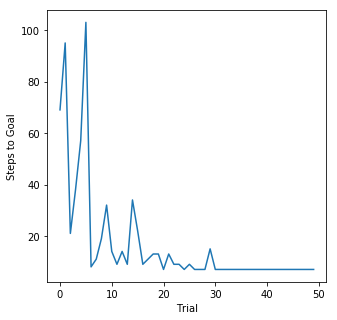

In [9]:
Q, stepsToGoal = trainQ(50, 0.5, 0.7, validMoves, makeMove, ploT = True)

In [10]:
stepsToGoal

array([  69.,   95.,   21.,   38.,   57.,  103.,    8.,   11.,   19.,
         32.,   14.,    9.,   14.,    9.,   34.,   22.,    9.,   11.,
         13.,   13.,    7.,   13.,    9.,    9.,    7.,    9.,    7.,
          7.,    7.,   15.,    7.,    7.,    7.,    7.,    7.,    7.,
          7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,
          7.,    7.,    7.,    7.,    7.])

In [11]:
path = testQ(Q, 20, validMoves, makeMove)

In [12]:
print("It took", len(path), "steps to get the goal")
path

It took 8 steps to get the goal


[[[1, 2, 3], [], []],
 [[2, 3], [], [1]],
 [[3], [2], [1]],
 [[3], [1, 2], []],
 [[], [1, 2], [3]],
 [[1], [2], [3]],
 [[1], [], [2, 3]],
 [[], [], [1, 2, 3]]]

In [13]:
for s in path:
    printState(s)
    print()

1     
2     
3     
------


2     
3   1 
------


3 2 1 
------


  1   
3 2   
------


  1   
  2 3 
------


1 2 3 
------


    2 
1   3 
------


    1 
    2 
    3 
------




## Grading

Download and extract `A5grader.py` from [A5grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A5grader.tar).

In [14]:
%run -i A5grader.py


Testing validMoves([[1], [2], [3]])

--- 10/10 points. Correctly returned [[1, 2], [1, 3], [2, 3]]

Testing validMoves([[], [], [1, 2, 3]])

--- 10/10 points. Correctly returned [[3, 1], [3, 2]]

Testing makeMove([[], [], [1, 2, 3]], [3, 2])

--- 10/10 points. Correctly returned [[], [1], [2, 3]]

Testing makeMove([[2], [3], [1]], [1, 2])

--- 10/10 points. Correctly returned [[], [2, 3], [1]]

Testing   Q, steps = trainQ(1000, 0.5, 0.7, validMoves, makeMove).

--- 10/10 points. Q dictionary has correct number of entries.

--- 10/10 points. The mean of the number of steps is 7.443 which is correct.

Testing   path = testQ(Q, 20, validMoves, makeMove).

--- 20/20 points. Correctly returns path of length 8, less than 10.

A5 Execution Grade is 80/80

 Remaining 20 points will be based on your text describing the trainQ and test! functions.

A5 FINAL GRADE is __/100


## Extra Credit

Modify your code to solve the Towers of Hanoi puzzle with 4 disks instead of 3.  Name your functions

    - printState_4disk
    - validMoves_4disk
    - makeMove_4disk

Find values for number of repetitions, learning rate, and epsilon decay factor for which trainQ learns a Q function that testQ can use to find the shortest solution path.  Include the output from the successful calls to trainQ and testQ.

In [15]:
state = [[1, 2, 3, 4], [], []]
printState(state)
print(validMoves(state))

print()
print()

state2 = [[1], [2], [3, 4]]
printState(state2)
print(validMoves(state2))

1     
2     
3     
4     
------

[[1, 2], [1, 3]]


    3 
1 2 4 
------

[[1, 2], [1, 3], [2, 3]]


In [16]:
# define 4disk game startState and endState
sState_4disk = [[1, 2, 3, 4], [], []]
eState_4disk = [[], [], [1, 2, 3, 4]]

In [17]:
# Testing my parameters
nRepetitions = 100
learningRate = 0.5
epsilonDecayFactor = 0.9

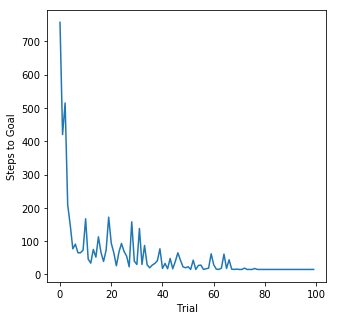

In [18]:
Q, stepsToGoal = trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMoves, makeMove, 
                        sState_4disk, eState_4disk, ploT = True)

In [19]:
path = testQ(Q, 20, validMoves, makeMove, sState_4disk, eState_4disk)
print("It took", len(path), "steps to get the goal")
path

It took 16 steps to get the goal


[[[1, 2, 3, 4], [], []],
 [[2, 3, 4], [1], []],
 [[3, 4], [1], [2]],
 [[3, 4], [], [1, 2]],
 [[4], [3], [1, 2]],
 [[1, 4], [3], [2]],
 [[1, 4], [2, 3], []],
 [[4], [1, 2, 3], []],
 [[], [1, 2, 3], [4]],
 [[], [2, 3], [1, 4]],
 [[2], [3], [1, 4]],
 [[1, 2], [3], [4]],
 [[1, 2], [], [3, 4]],
 [[2], [1], [3, 4]],
 [[], [1], [2, 3, 4]],
 [[], [], [1, 2, 3, 4]]]